# 医薬情報テキストマイニングチャレンジ

* [コンテスト詳細 ビッグデータ活用ならオプトDSL DeepAnalytics](https://deepanalytics.jp/compe/38/)

## Preprocess

In [2]:
import numpy as np
import pandas as pd
from IPython.display import FileLink

In [3]:
data = pd.read_table('data/train.tsv')
test = pd.read_table('data/test.tsv', header=None)
num = len(data)
test_num = len(test)

In [4]:
data.head(10)

,before,after
0,便塊除去,摘便
1,アルツハイマ-認知症,アルツハイマー型認知症
2,熱傷（背部）,背部熱傷、程度不明（部位を限定しない）
3,2015.8.12骨盤-その他-前立腺癌,前立腺癌
4,口のにがみ,苦味
5,軽度呼吸困難感,呼吸困難
6,両足関節偽痛風,偽痛風
7,内痔核出血,痔出血
8,背部皮脂欠乏性湿疹,皮脂欠乏性湿疹
9,左側頭葉出血,脳出血


In [5]:
len(data['after'].drop_duplicates())

4217

## Mecab をインストールする

まずは、MeCabをインストール。

       sudo apt-get install mecab mecab-naist-jdic mecab-ipadic-utf8 libmecab-dev
       pip install mecab-python3

Mecabには、医療辞書を使う(ComJisyo) 
[リリース ComeJisyo Linux用システム辞書 \- ComeJisyo \- OSDN](https://ja.osdn.net/projects/comedic/releases/44305)

インストールでは、utf-8でインストールすることが必要。

    ./configure --with-charset-=utf8　

* [MeCabをUTF-8でインストールしたい。 - Qiita](http://qiita.com/junpooooow/items/0a7d13addc0acad10606)

In [6]:
import MeCab
#m = MeCab.Tagger("-Owakati")
m = MeCab.Tagger("-Ochasen")
#data['before'] = data['before'].apply(m.parseToNode)
#test1 = test[0].apply(m.parseToNode)

In [7]:
node = m.parseToNode("足がふらつく")
while node:
    print(node.feature)
    node = node.next

BOS/EOS,*,*,*,*,*,*,*,*
名詞,一般,*,*,*,*,足,アシ,アシ
助詞,格助詞,一般,*,*,*,が,ガ,ガ
動詞,自立,*,*,五段・カ行イ音便,基本形,ふらつく,フラツク,フラツク
BOS/EOS,*,*,*,*,*,*,*,*


In [8]:
befores = set()
afters = set()
for i, row in data.iterrows():
    node = m.parseToNode(row[0])
    while node:
        if node.feature.startswith('名詞'):
            befores.add(node.surface)
        if node.feature.startswith('形容詞'):
            befores.add(node.surface)
        if node.feature.startswith('動詞'):
            befores.add(node.surface)
        node = node.next
    afters.add(row[1])

for i in test[0].iteritems():
    node = m.parseToNode(i[1])
    while node:
        if node.feature.startswith('名詞'):
            befores.add(node.surface)
        if node.feature.startswith('形容詞'):
            befores.add(node.surface)
        if node.feature.startswith('動詞'):
            befores.add(node.surface)
        node = node.next

In [9]:
vocab_size = len(befores)
out_size = len(afters)

In [10]:
from collections import Counter

def create_lookup_tables(words):
    word_counts = Counter(words)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab
before_to_int, int_to_before = create_lookup_tables(befores)
after_to_int, int_to_after = create_lookup_tables(afters)

In [11]:
lens = data['before'].apply(len)
(lens.max(), lens.min(), lens.mean(), lens.median(), lens.var())

(82, 1, 8.30282208588957, 7.0, 20.92056222497029)

/home/tsu-nera/anaconda3/envs/opt/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


(array([  4.00000000e+00,   1.04000000e+02,   3.53000000e+02,
          1.06500000e+03,   1.59700000e+03,   0.00000000e+00,
          1.88700000e+03,   1.55900000e+03,   1.32000000e+03,
          9.82000000e+02,   0.00000000e+00,   7.35000000e+02,
          6.18000000e+02,   4.51000000e+02,   3.20000000e+02,
          0.00000000e+00,   2.51000000e+02,   1.90000000e+02,
          1.75000000e+02,   1.55000000e+02,   8.40000000e+01,
          0.00000000e+00,   6.30000000e+01,   5.10000000e+01,
          4.10000000e+01,   3.50000000e+01,   0.00000000e+00,
          2.70000000e+01,   2.30000000e+01,   2.10000000e+01,
          2.10000000e+01,   0.00000000e+00,   9.00000000e+00,
          1.10000000e+01,   9.00000000e+00,   7.00000000e+00,
          0.00000000e+00,   1.20000000e+01,   7.00000000e+00,
          2.00000000e+00,   6.00000000e+00,   4.00000000e+00,
          0.00000000e+00,   3.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   0.00000000e+00,
        

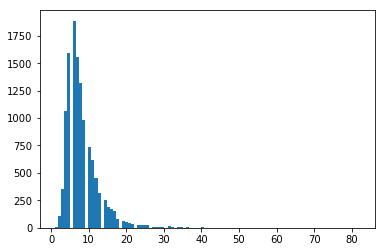

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(lens, bins=100)

In [15]:
#seq_len = 20
m2 = MeCab.Tagger("-Owakati")
data['before'] = data['before'].apply(m2.parse)

In [16]:
trainX, trainY= [], []
for i, row in data.iterrows():
    xl = []
    for w in row['before'].split():
#        if len(xl) < seq_len:
        try:
            xl.append(before_to_int[w])
        except KeyError:
            pass
    trainX.append(xl)
    trainY.append(after_to_int[row['after']])

In [17]:
#len(trainX), len(trainY)
trainX[:10], trainY[:10]

([[248, 5246, 6649],
  [2352, 142, 6813],
  [9228, 3750],
  [932, 2278, 9258, 2278, 5791, 9225, 142, 1839, 142, 262],
  [3838, 8267, 7229],
  [6681, 7690, 1378],
  [5063, 7516, 1952],
  [8933, 2505],
  [3750, 6869, 7841, 7203, 3610],
  [3333, 6768, 2505]],
 [2830, 2552, 1798, 445, 1334, 1274, 3572, 2267, 2707, 2592])

In [18]:
test1 = test[0].apply(m2.parse)

In [19]:
testX = []

for i, row in test1.iteritems():
    xl = []
    for w in row.split():
        try:
            xl.append(before_to_int[w])
        except KeyError:
            pass
    testX.append(xl)

In [ ]:
seq_len = 20
from keras.preprocessing import sequence
trainX = sequence.pad_sequences(trainX, maxlen=seq_len, value=0, padding='post')
testX = sequence.pad_sequences(testX, maxlen=seq_len, value=0, padding='post')

Using TensorFlow backend.


In [18]:
trainX[:10], trainY[:10], testX[:10]

(array([[2263, 6410, 8185,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [9004, 8743, 5013,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [8277, 3738,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [7130, 4642, 3242, 4642, 4765, 5411, 8743, 7153, 8743, 8194,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [4495, 4093, 3699,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [2233, 5533, 8602,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [9104, 6746, 4663,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [7816, 2167,    0, 

In [19]:
from keras.utils.np_utils import to_categorical
trainX = np.array(trainX)
trainY = np.array(trainY)
testX = np.array(testX)
validX = trainX[:2225]
trainX = trainX[2225:]
trainY = to_categorical(trainY)
validY = trainY[:2225]
trainY = trainY[2225:]
trainX.shape, trainY.shape, validX.shape, validY.shape, testX.shape

((10000, 20), (10000, 4217), (2225, 20), (2225, 4217), (12226, 20))

## Build Model

In [20]:
import keras
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, SpatialDropout1D, BatchNormalization
from keras.layers.core import Flatten, Dense, Dropout
from keras.optimizers import Adam, Adagrad, Nadam

In [21]:
batch_size = 64

### Multi-size CNN
* [Quid](https://quid.com/feed/how-quid-uses-deep-learning-with-small-data)

In [26]:
from keras.models import Model
from keras.layers import Input, Merge, AveragePooling1D, Activation, GlobalAveragePooling1D
from keras.layers.merge import Concatenate
from keras.layers.advanced_activations import PReLU

In [27]:
nf = 256
p = 0.5

In [28]:
def get_model():
    return [
    Embedding(vocab_size, 50, input_length=seq_len),
    Conv1D(nf,3, padding='same'),
    PReLU(),
    BatchNormalization(axis=1),
    MaxPooling1D(),
    Conv1D(nf,3, padding='same'),
    PReLU(),
    BatchNormalization(axis=1),
    MaxPooling1D(),
    Conv1D(nf,3, padding='same'),
    PReLU(),
    BatchNormalization(axis=1),
    MaxPooling1D(),
    Conv1D(nf,3, padding='same'),
    PReLU(),
    BatchNormalization(axis=1),
    MaxPooling1D(),
    Conv1D(out_size,3, padding='same'),
    PReLU(),
    BatchNormalization(axis=1),
    Dropout(p),
    GlobalAveragePooling1D(),
    Activation('softmax')
    ]

In [29]:
conv2 = Sequential(get_model())

In [30]:
conv2.compile(loss='categorical_crossentropy', optimizer=Nadam(), metrics=['accuracy'])

In [31]:
conv2.fit(trainX, trainY, validation_data=(validX, validY), epochs=80, batch_size=batch_size)

Train on 10000 samples, validate on 2225 samples
Epoch 1/80
 1600/10000 [===>..........................] - ETA: 216s - loss: 12.0905 - acc: 0.0056    

KeyboardInterrupt: 

In [ ]:
conv2.fit(trainX, trainY, validation_data=(validX, validY), epochs=5, batch_size=batch_size)

## Test

In [ ]:
preds = model.predict(testX)

In [ ]:
preds = conv2.predict(testX)

In [ ]:
preds.shape

In [ ]:
i1 = np.argmax(preds[0])
int_to_after[i1], i1

In [ ]:
out = pd.DataFrame(columns=["before", "after"])
for i in range(0, test_num):
    for id in np.argsort(preds[i])[::-1][:3]:
        series = pd.DataFrame([[test[0][i], int_to_after[id]]], columns=out.columns)
        out = out.append(series)

In [ ]:
subm_name = "submission_conv2_20.tsv"
out.to_csv(subm_name, sep='\t', index=False, header=False)

In [ ]:
FileLink(subm_name)